In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import io

# Data acquisition files

In [72]:
ds_path = Path('/media/monaco/DATA1/case_study/24h_10mmMAX_OI/')
all_events = pd.read_csv(ds_path / 'split/cluster_all_dates.csv', sep=';')

all_events = all_events[['DATA', 'CLUSTER', 'NAME']].set_index('DATA')

other_events = set([int(f.stem.split('_')[1]) for f in (ds_path / 'obs').rglob('*_regrid.csv')])
other_events = pd.DataFrame(other_events, columns=['DATA'])
all_events = all_events.join(other_events.set_index('DATA'), how='outer')

all_events['CLUSTER'] = all_events['CLUSTER'].fillna(2)
all_events['NAME'] = all_events['NAME'].fillna('convective')
all_events = all_events.reset_index()

intense_events = [int(f.stem.split('_')[1]) for f in (ds_path / 'obs/data_intenseEvents').rglob('*csv')]
all_events['INTENSE'] = all_events['DATA'].isin(intense_events)

def find_observation(date, topdir):
    case_study = topdir.stem.split('_')[-1] # OI | radar
    filename = f"{case_study}_{date}_regrid.csv"
    file_path = list((topdir / "obs").rglob(filename))
    if len(file_path) > 1:
        maps = [pd.read_csv(f, header=None, delimiter=';').values for f in file_path] # assert they are the same
        if not all(np.allclose(maps[0], m) for m in maps[1:]):
            print(ValueError(f"Multiple files found for '{filename}': {file_path}"))
        file_path1 = [f for f in file_path if 'intense' in f.as_posix().lower()]
        if file_path1:
            file_path = file_path1
    return file_path[0].relative_to(topdir)

def find_forecast(date, model_name, topdir):
    filename = f"{model_name}_{date}_0024_regrid.csv"
    file_path = list((topdir / "models").rglob(filename))
    if len(list(file_path)) > 1:
        maps = [pd.read_csv(f, header=None, delimiter=';').values for f in file_path]
        if not all(np.allclose(maps[0], m) for m in maps[1:]):
            raise ValueError(f"Multiple files found for '{filename}': {file_path}")
        file_path1 = [f for f in file_path if 'intense' in f.as_posix().lower()]
        if file_path1:
            file_path = file_path1
    return file_path[0].relative_to(topdir)

all_events['OBS'] = all_events['DATA'].apply(lambda x: find_observation(x, ds_path))
for nwp in ["bol00", "e1000", "c2200", "c5m00"]:
    all_events[f"{nwp.upper()}"] = all_events['DATA'].apply(lambda x: find_forecast(x, nwp, ds_path))



all_events.to_csv(ds_path / 'allevents_dates.csv', sep=';', index=False)

Multiple files found for 'OI_20220523_regrid.csv': [PosixPath('/media/monaco/DATA1/case_study/24h_10mmMAX_OI/obs/data/OI_20220523_regrid.csv'), PosixPath('/media/monaco/DATA1/case_study/24h_10mmMAX_OI/obs/data_extremeEvents/old_dataset/OI_20220523_regrid.csv')]


In [76]:
all_events

,CLUSTER,NAME,INTENSE,OBS,BOL00,E1000,C2200,C5M00,AVG_OBS,STD_OBS,MAX_OBS,MIN_OBS
DATA,,,,,,,,,,,,
20180530,1.0,stratiform,False,obs/data/OI_20180530_regrid.csv,models/bol00_20180530_0024_regrid.csv,models/e1000_20180530_0024_regrid.csv,models/c2200_20180530_0024_regrid.csv,models/c5m00_20180530_0024_regrid.csv,15.554299,7.258272,54.330093,5.840000e-01
20180531,0.0,intermediate,False,obs/data/OI_20180531_regrid.csv,models/bol00_20180531_0024_regrid.csv,models/e1000_20180531_0024_regrid.csv,models/c2200_20180531_0024_regrid.csv,models/c5m00_20180531_0024_regrid.csv,2.944318,2.935492,18.483887,-6.505213e-15
20180603,0.0,intermediate,False,obs/data/OI_20180603_regrid.csv,models/bol00_20180603_0024_regrid.csv,models/e1000_20180603_0024_regrid.csv,models/c2200_20180603_0024_regrid.csv,models/c5m00_20180603_0024_regrid.csv,1.894837,2.234981,19.557129,-2.219752e-14
20180604,1.0,stratiform,False,obs/data/OI_20180604_regrid.csv,models/bol00_20180604_0024_regrid.csv,models/e1000_20180604_0024_regrid.csv,models/c2200_20180604_0024_regrid.csv,models/c5m00_20180604_0024_regrid.csv,14.884314,6.632705,43.619431,4.290000e-01
20180606,1.0,stratiform,False,obs/data/OI_20180606_regrid.csv,models/bol00_20180606_0024_regrid.csv,models/e1000_20180606_0024_regrid.csv,models/c2200_20180606_0024_regrid.csv,models/c5m00_20180606_0024_regrid.csv,6.751457,5.796503,42.363281,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...
20240227,2.0,convective,True,obs/data_intenseEvents/new_dataset/OI_20240227...,models/data_intenseEvents/new_dataset/bol00_20...,models/data_intenseEvents/new_dataset/e1000_20...,models/data_intenseEvents/new_dataset/c2200_20...,models/data_intenseEvents/new_dataset/c5m00_20...,35.267043,10.674709,66.373726,5.028999e+00
20240303,2.0,convective,True,obs/data_intenseEvents/new_dataset/OI_20240303...,models/data_intenseEvents/new_dataset/bol00_20...,models/data_intenseEvents/new_dataset/e1000_20...,models/data_intenseEvents/new_dataset/c2200_20...,models/data_intenseEvents/new_dataset/c5m00_20...,42.396563,16.758419,105.687920,2.268000e+00
20240318,2.0,convective,False,obs/data_extremeEvents/new_dataset/OI_20240318...,models/data_extremeEvents/new_dataset/bol00_20...,models/data_extremeEvents/new_dataset/e1000_20...,models/data_extremeEvents/new_dataset/c2200_20...,models/data_extremeEvents/new_dataset/c5m00_20...,1.282330,2.448377,21.548828,-5.162537e-15


In [6]:
splitdir = Path("/media/monaco/DATA1/case_study/24h_10mmMAX_OI/split")
convective = pd.read_csv(splitdir / "cluster_convective.csv", sep=";")
intermediate = pd.read_csv(splitdir / "cluster_intermediate.csv", sep=";")
stratiform = pd.read_csv(splitdir / "cluster_stratiform.csv", sep=";")

dates = pd.concat([
    convective.assign(NAME="convective"),
    intermediate.assign(NAME="intermediate"),
    stratiform.assign(NAME="stratiform")
])

In [7]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=9, random_state=42, shuffle=True)
n_split = 2
train_index, test_index = list(skf.split(dates, dates.NAME))[n_split]
val_index, train_index = np.split(train_index, [len(test_index)])

print(len(train_index), len(val_index), len(test_index))

314 45 45


# Ds statistics

In [74]:
from pathlib import Path
import pandas as pd
from utils import io

ds_path = Path('/media/monaco/DATA1/case_study/24h_10mmMAX_OI/')
all_events = pd.read_csv(ds_path / 'allevents_dates.csv', sep=';', index_col='DATA')

case_study_max, available_models, train_dates, val_dates, test_dates, indices_one, indices_zero, mask, nx, ny = io.get_casestudy_stuff(
			ds_path, n_split=0, case_study='24h_10mmMAX_OI', ispadded=True,
			seed=42
		)

def get_avg_precipitation(data, agg='mean'):
    values = pd.read_csv(ds_path / data, sep=';', header=None).values# * mask
    if agg == 'mean':
        return values.mean()
    elif agg == 'std':
        return values.std()
    elif agg == 'max':
        return values.max()
    elif agg == 'min':
        return values.min()
    elif isinstance(agg, float) and 0 <= agg <= 1:
        return np.quantile(values, agg)
    

all_events['AVG_OBS'] = all_events['OBS'].apply(get_avg_precipitation)
all_events['STD_OBS'] = all_events['OBS'].apply(lambda x: get_avg_precipitation(x, 'std'))
all_events['MAX_OBS'] = all_events['OBS'].apply(lambda x: get_avg_precipitation(x, 'max'))
all_events['MIN_OBS'] = all_events['OBS'].apply(lambda x: get_avg_precipitation(x, 'min'))

/home/monaco/miniconda3/envs/monacoMM/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/monaco/miniconda3/envs/monacoMM/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/monaco/miniconda3/envs/monacoMM/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/monaco/miniconda3/envs/monacoMM/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

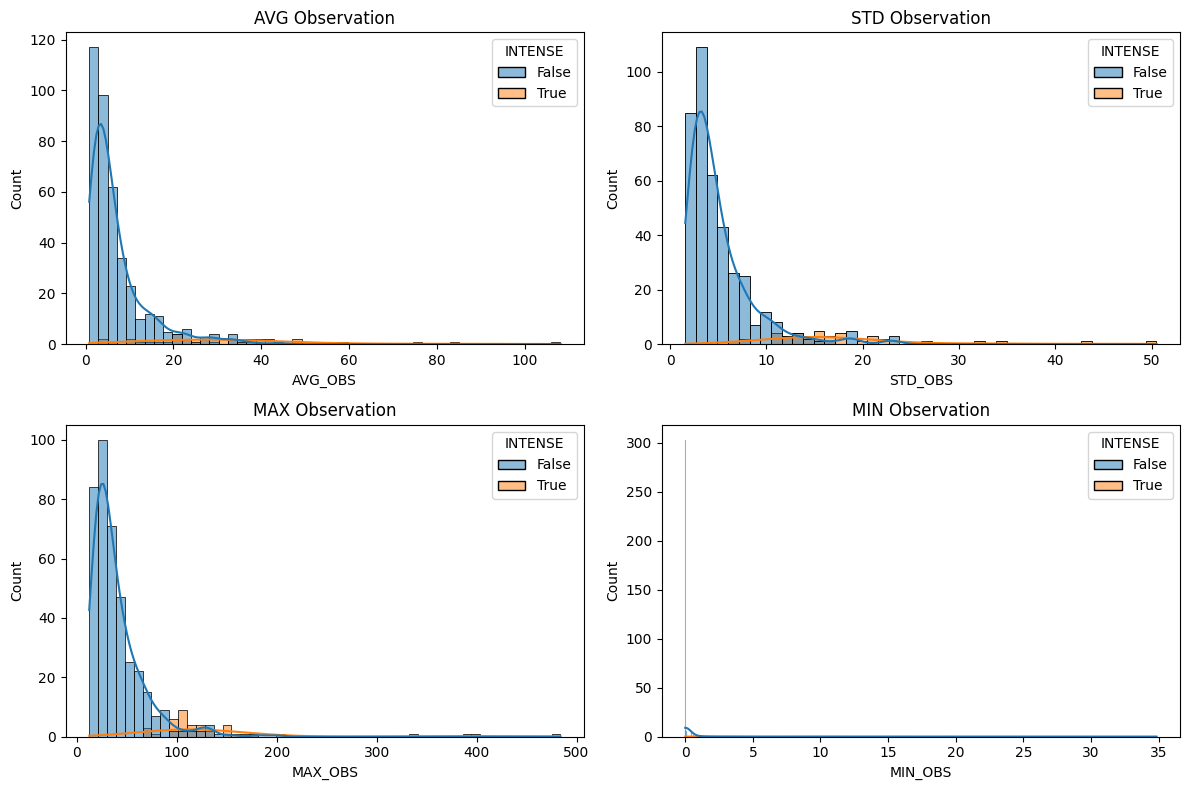

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax = ax.ravel()

for i, agg in enumerate(['AVG', 'STD', 'MAX', 'MIN']):
    sns.histplot(data=all_events, x=f'{agg.upper()}_OBS', hue='INTENSE', ax=ax[i], kde=True)
    ax[i].set_title(f'{agg} Observation')

plt.tight_layout()

# Result analysis

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# res = pd.read_csv("results.csv")

# # table structure: model, split, RMSE, AUROC, AUPR_in, AUPR_out
# # return a pivot table with the mean and std of the metrics for each model (as rows) and metrics (as columns)
# res.pivot_table(index='model', values=['RMSE_in', 'RMSE_out'], aggfunc=['mean', 'std'])

In [4]:
r1 = pd.read_csv("fine_rmseresults.csv")
r1_1 = pd.read_csv("fine_picpresults.csv")

In [6]:
r1_1.head()

,model,split,PICP,MPWI,NMPIL,RMSE,isintense
0,nwp,0,0.758857,0.036053,0.036053,0.031521,1
1,nwp,0,0.807851,0.014831,0.056807,0.011556,0
2,sde_unet,0,0.601325,0.003446,0.003446,0.026572,1
3,sde_unet,0,0.653631,0.002938,0.011254,0.008060,0
4,ensemble_unet,0,0.605677,0.006697,0.006697,0.028191,1


In [11]:
r1_1.model.unique()

array(['nwp', 'sde_unet', 'ensemble_unet', 'mcd_unet',
       'linear_regression'], dtype=object)

In [21]:
r1_1 = pd.read_csv("fine_picpresults.csv")

def aggfun(a):
    return f"${a.mean():.3f} {{\scriptstyle \pm {a.sem():.3f} }}$"

model_weights = {
    'nwp': '-',
    'linear_regression': '-',
    'ensemble_unet': '$5 \\times 31.0$',
    'mcd_unet': '$31.0$',
    'sde_unet': '$12.4$'
}
r1_1['# Parameters (M)'] = r1_1.model.map(model_weights)
r1_1.isintense = pd.Categorical(r1_1.isintense, [0, 1]).rename_categories({0: 'Typical', 1: 'Intense'})
r1_1.model = pd.Categorical(r1_1.model, ['nwp','linear_regression', 'ensemble_unet', 'mcd_unet', 'sde_unet'])
# all_results['size'] = pd.Categorical(all_results['size'], ['Small', 'Medium', 'Large'])
# all_results.dataset = pd.Categorical(all_results.dataset, ['cyst', 'LiTS'])
# all_results.metric = pd.Categorical(all_results.metric, ['Pr', 'Re', 'IoU'])

# pv = all_results.pivot_table(index=['dataset', 'model'], columns=['metric', 'size'], values='values', aggfunc=aggfun, observed=True)
# # print(pv.to_latex())
# all_results.pivot_table(index=['dataset', 'model'], columns=['metric', 'size'], values='values', aggfunc='std', observed=True).style.highlight_max(axis=0).format("{:.3f}")

tmp = r1_1.pivot_table(index='model', columns='isintense', values=['RMSE', 'PICP','MPWI'], aggfunc=aggfun, observed=True).round(3)
tmp['# Parameters (M)'] = r1_1.groupby('model', observed=True)['# Parameters (M)'].first()
print(tmp[['# Parameters (M)', 'RMSE', 'PICP', 'MPWI']].to_latex())

ImportError: Missing optional dependency 'Jinja2'. DataFrame.style requires jinja2. Use pip or conda to install Jinja2.

In [69]:
import numpy as np

r1_1 = pd.read_csv("fine_picpresults.csv")

ci = 0.95
alpha = np.linspace(0, 10, 20)
CWC= lambda MPIW, PICP, alpha: MPIW*(1 + np.exp(-alpha*(PICP - ci)))

r1_1 = r1_1[r1_1['split'] == 0]
r1_1['model_intense'] = r1_1['model'] + r1_1['isintense'].astype(str)

# MPIW_array: np.array of shape (n_models*{isintense}, n_splits)
# PICP_array: np.array of shape (n_models*{isintense}, n_splits)
# reshape them to perform the operation on all models and splits at once
MPIW_array = r1_1.pivot_table(index='model_intense', columns='split', values='MPWI')
model_intense = MPIW_array.index
split = MPIW_array.columns
MPIW_array = MPIW_array.values.reshape(model_intense.nunique(), split.nunique(), 1)
PICP_array = r1_1.pivot_table(index='model_intense', columns='split', values='PICP').values.reshape(model_intense.nunique(), split.nunique(), 1)

alpha = np.linspace(0, 10, 20).reshape(1, 1, -1)
# get a tensor with shape (n_models*{isintense}, n_splits, n_alpha)
CWC_array = MPIW_array * (1 + alpha*(1 - ci - PICP_array).clip(0))

CWC_df = pd.DataFrame(CWC_array.mean(axis=1).reshape(-1, alpha.shape[-1]), index=model_intense, columns=alpha[0, 0])

CWC_df = CWC_df.reset_index().melt(var_name='alpha', value_name='CWC', id_vars='model_intense')
CWC_df['isintense'] = CWC_df['model_intense'].str.extract(r'(\d)')
CWC_df['model'] = CWC_df['model_intense'].str.extract(r'([a-zA-Z]+)')
CWC_df['alpha'] = CWC_df['alpha'].astype(float)


In [72]:
import numpy as np

r1_1 = pd.read_csv("fine_picpresults.csv")

ci = 0.95
alpha = np.linspace(0, 10, 20)

r1_1 = r1_1[r1_1['split'] == 0].groupby(['model', 'isintense']).mean()

rAlpha = pd.DataFrame()
for a in alpha:
    cwc = r1_1.apply(lambda x: CWC(x['MPWI'], x['PICP'], a), axis=1)
    rAlpha = pd.concat([rAlpha, r1_1.assign(alpha=a, CWC=cwc)], axis=0)

rAlpha = rAlpha.reset_index()


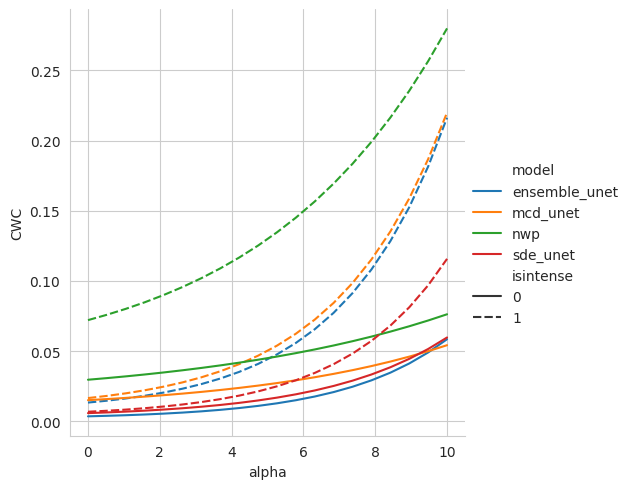

In [76]:

sns.relplot(data=rAlpha, x='alpha', y='CWC', hue='model', style='isintense', kind='line')
# sns.lineplot(data=rAlpha, x='alpha', y='MPWI', hue='model', style='isintense')

In [63]:

r1_1.pivot_table(index='model', columns='isintense', values=['PICP','MPWI'], aggfunc=['mean', 'sem']).round(3)

mean                     
                MPWI          PICP       
isintense          0      1      0      1
model                                    
ensemble_unet  0.002  0.006  0.603  0.604
mcd_unet       0.007  0.008  0.755  0.623
nwp            0.014  0.034  0.792  0.745
sde_unet       0.003  0.003  0.647  0.599

In [19]:
r1.pivot_table(index='model', columns='isintense', values='RMSE', aggfunc=['mean', 'sem']).round(3)

models_map = {'nwp': 'NWP', 'linear_regression': 'Linear Regression',
              'mcd_unet': 'MCD U-Net', 'ensemble_unet': 'Ensemble U-Net', 
              'sde_unet': 'SDE U-Net',
              #'sde_unet_small': 'SDE U-Net (S)', 'unet': 'U-Net',
              }
isintense_map = {0: 'Non Intense', 1: 'Intense'}
r1['model'] = r1['model'].map(models_map)
r1['isintense'] = r1['isintense'].map(isintense_map)

Text(0.5, 0, '')

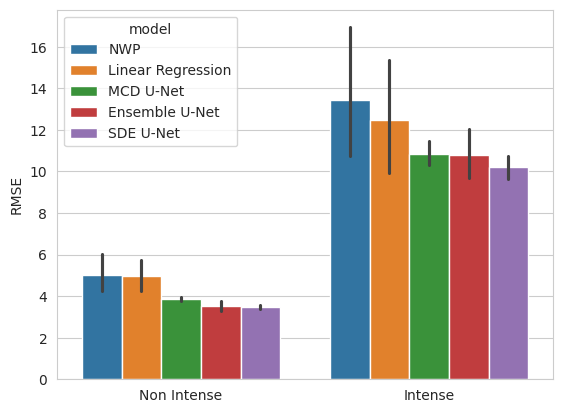

In [20]:
sns.barplot(data=r1[r1.split.eq(0)], 
            x='isintense', y='RMSE', hue='model', hue_order=models_map.values())
plt.xlabel(None)

### 🚨 **TODO:**

Creare una mega tabella con 10 rMSE per ogni split per ogni immagine (campionamenti dei modelli, 5 per ensemble)
Stessa cosa per il brier score, tirare fuori il valore a partire 
 - dall'aggregazione dei 10 modelli dello split,
 - dall'aggregazione dei 9 split e poi mediata +- deviazione standard

Text(0.5, 1.0, 'Intense Events')

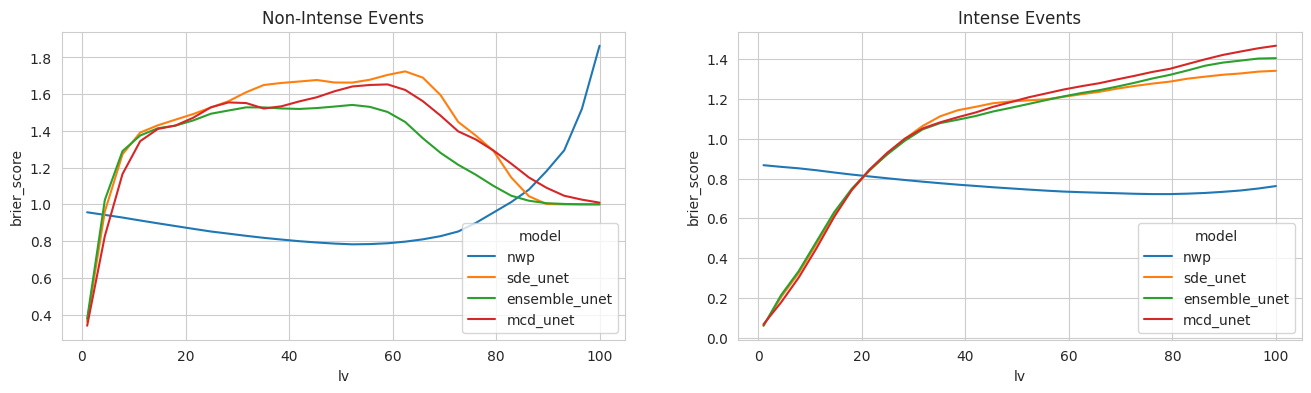

In [46]:
brier_res = pd.read_csv("fine_brierresults.csv")
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
sns.lineplot(data=brier_res[brier_res.intense.eq(0)&brier_res.split.eq(0)], x='lv', y='brier_score', hue='model', ax=ax[0])
ax[0].set_title('Non-Intense Events')
sns.lineplot(data=brier_res[brier_res.intense.eq(1)&brier_res.split.eq(0)], x='lv', y='brier_score', hue='model', ax=ax[1])
ax[1].set_title('Intense Events')

# for a in ax:
#     a.set_yscale('log')

Text(0.5, 1.0, 'Intense Events')

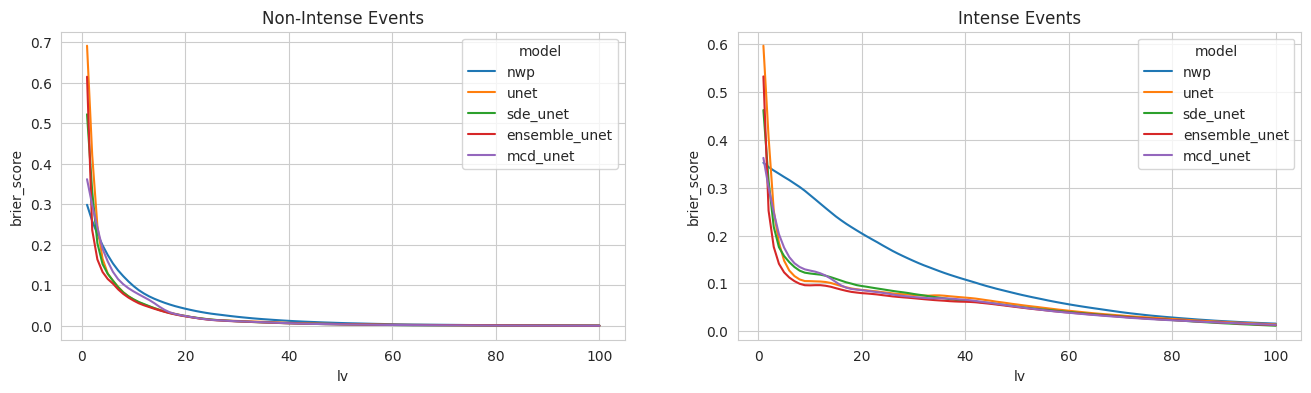

In [45]:
brier_res = pd.read_csv("old/fine_brierresults.csv")
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
sns.lineplot(data=brier_res[brier_res.intense.eq(0)&brier_res.split.eq(0)], x='lv', y='brier_score', hue='model', ax=ax[0])
ax[0].set_title('Non-Intense Events')
sns.lineplot(data=brier_res[brier_res.intense.eq(1)&brier_res.split.eq(0)], x='lv', y='brier_score', hue='model', ax=ax[1])
ax[1].set_title('Intense Events')

# for a in ax:
#     a.set_yscale('log')

In [5]:
brier_res

,model,split,lv,brier_intense,intense
0,nwp,0,1.0,0.352155,1
1,nwp,0,1.0,0.298526,0
2,nwp,0,2.0,0.343211,1
3,nwp,0,2.0,0.258386,0
4,nwp,0,3.0,0.335965,1
...,...,...,...,...,...
7395,mcd_unet,8,98.0,0.000000,0
7396,mcd_unet,8,99.0,0.011572,1
7397,mcd_unet,8,99.0,0.000000,0
7398,mcd_unet,8,100.0,0.011253,1


---

<Axes: xlabel='model', ylabel='value'>

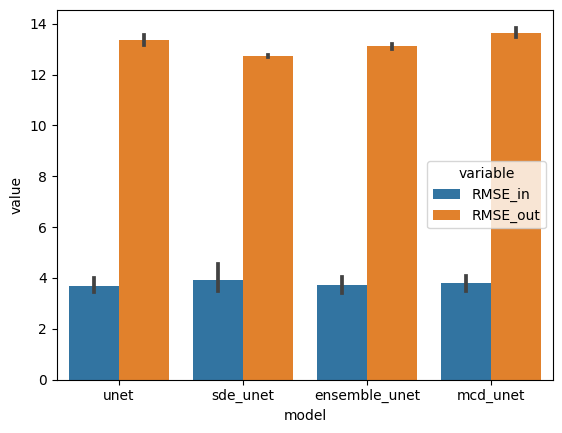

In [ ]:
# todo aggiungere singoli modelli input
sns.barplot(data=pd.melt(res, id_vars=['model', 'split'], value_vars=['RMSE_in', 'RMSE_out']),
            x='model', y='value', hue='variable')
# sns.barplot(data=res, x='model', y='RMSE_in', hue='split')

/home/monaco/miniconda3/envs/monacoMM/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/monaco/miniconda3/envs/monacoMM/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


<Axes: xlabel='model', ylabel='value'>

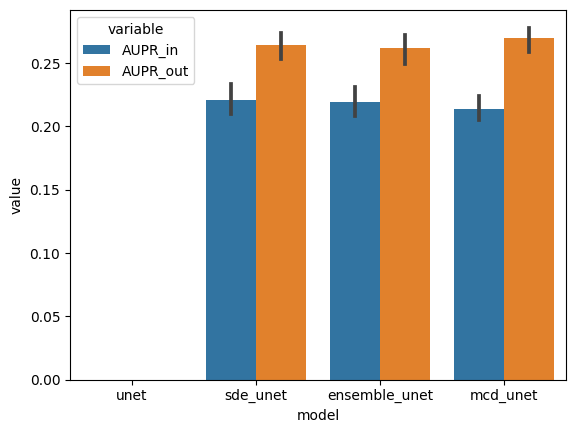

In [14]:
sns.barplot(data=pd.melt(res, id_vars=['model', 'split'], value_vars=['AUPR_in', 'AUPR_out']),
            x='model', y='value', hue='variable')
# sns.barplot(data=res, x='model', y='RMSE_in', hue='split')

In [4]:
res.pivot_table(index='model', values=['AUROC', 'AUPR_out', 'AUPR_in'], aggfunc=['mean'])

mean                    
                AUPR_in  AUPR_out     AUROC
model                                      
ensemble_unet  0.219611  0.262230  0.268955
mcd_unet       0.213762  0.269804  0.261536
sde_unet       0.220718  0.264676  0.267847

Out-of-distribution detection for regression on the dataset, where OoD are some extreme events hidden at train time.
We report the average performance and standard deviation for 9 random splits. All the  model performance is compared in terms of RMSE, AUROC, and AUPR.

In [5]:
import torch

def plot_AUC_AUPR_curve(pred_variance: torch.Tensor, target: torch.Tensor):
    """
    preds_mean and pred_std have shape (N, 1, H, W), target has shape (N) and is a binary tensor saying if the nth event is an OoD one
    """
    avg_variance = pred_variance.mean(dim=(1, 2, 3))
    curve_steps = 1000
    auroc = []
    aupr_out = []
    aupr_in = []
    for delta in torch.arange(avg_variance.min(), avg_variance.max(), (avg_variance.max() - avg_variance.min()) / curve_steps):
        tpr = (avg_variance > delta).float().eq(target).float().mean().item()
        fpr = (avg_variance > delta).float().ne(target).float().mean().item()
        auroc.append((fpr, tpr))
        precision_out = (avg_variance > delta).float().ne(target).float().mean().item()
        recall_out = (avg_variance > delta).float().ne(target).float().mean().item()
        aupr_out.append((recall_out, precision_out))
        precision_in = (avg_variance > delta).float().eq(target).float().mean().item()
        recall_in = (avg_variance > delta).float().eq(target).float().mean().item()
        aupr_in.append((recall_in, precision_in))
    auroc = np.array(auroc)
    aupr_out = np.array(aupr_out)
    aupr_in = np.array(aupr_in)
    plt.figure()
    plt.plot(auroc[:, 0], auroc[:, 1], label="AUROC")
    plt.plot(aupr_out[:, 0], aupr_out[:, 1], label="AUPR_out")
    plt.plot(aupr_in[:, 0], aupr_in[:, 1], label="AUPR_in")
    plt.legend()
    plt.show()

/home/monaco/miniconda3/envs/monacoMM/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/monaco/miniconda3/envs/monacoMM/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/monaco/miniconda3/envs/monacoMM/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/monaco/miniconda3/envs/monacoMM/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

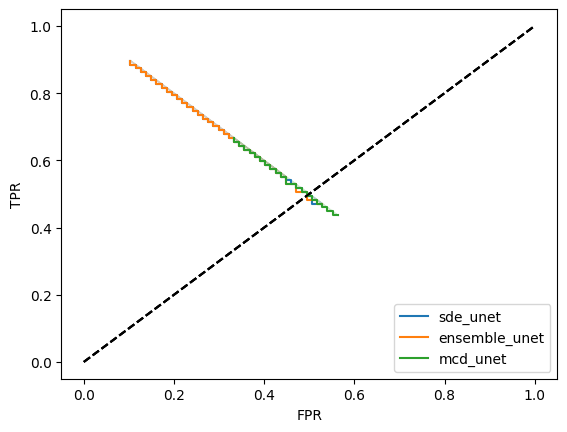

In [7]:
from pathlib import Path
from utils.datasets import IntenseDataset
from torch.utils.data import DataLoader
num_repetitions = 5
from training import get_model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

split = 2
extreme_ds = IntenseDataset(split, input_path=Path('/media/monaco/DATA1/case_study/24h_10mmMAX_OI/'))
extreme_dl = DataLoader(extreme_ds, batch_size=len(extreme_ds), shuffle=True)

fig, ax = plt.subplots()
for model_name in ['sde_unet', 'ensemble_unet', 'mcd_unet']:
    checkpoint_path = Path(f"lightning_logs/{model_name}/split_{split}/")
    if not checkpoint_path.exists():
        print(f"\n>> Skipping model {model_name} for split {split}")
        continue

    ckpt = list(checkpoint_path.glob("*.ckpt"))
    assert len(ckpt) == 1
    ckpt = ckpt[0]
    model = get_model(model_name).load_from_checkpoint(ckpt)
    model.eval()

    data = next(iter(extreme_dl))
    x = data['x'].to(model.device)
    y = data['y'].to(model.device)
    extremeev_label = data['isintense'].to(model.device)
    pred_mean, pred_variance = model.multiple_eval(x, num_forward_passes=num_repetitions)

    avg_variance = pred_variance.mean(dim=(1, 2, 3))
    curve_steps = 1000
    auroc = []
    for delta in torch.arange(avg_variance.min(), avg_variance.max(), (avg_variance.max() - avg_variance.min()) / curve_steps):
        tpr = (avg_variance > delta).float().eq(extremeev_label).float().mean().item()
        fpr = (avg_variance > delta).float().ne(extremeev_label).float().mean().item()
        auroc.append((fpr, tpr))
    auroc = np.array(auroc)
    
    sns.lineplot(x=auroc[:, 0], y=auroc[:, 1], label=model_name, ax=ax, drawstyle='steps-pre')
    plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

In [78]:
res.pivot_table(index='model', values=['AUROC', 'AUPR_in', 'AUPR_out'], aggfunc='mean').style.highlight_max()

,AUPR_in,AUPR_out,AUROC
model,,,
ensemble_unet,0.219611,0.262230,0.268955
mcd_unet,0.213470,0.270792,0.261829
sde_unet,0.218933,0.265634,0.266890


# Xtreme events

In [8]:
input_path = Path('/media/monaco/DATA1/case_study')
n_split = 8
case_study = '24h_10mmMAX_OI'
input_path = input_path / case_study
use_extreme = False

case_study_max, available_models, train_dates, val_dates, test_dates, indices_one, indices_zero, mask, nx, ny = io.get_casestudy_stuff(
    input_path, n_split, case_study=case_study, ispadded=True,
    seed=42
)

print(len(train_dates), len(val_dates), len(test_dates), sum(len(x) for x in [train_dates, val_dates, test_dates]))

from sklearn.model_selection import train_test_split
test_dates1 = pd.concat([pd.read_csv(exev, header=None) for exev in input_path.glob('*extremeEvents.csv')])[0].values
train_dates = np.array(list(set(train_dates).union(val_dates).union(test_dates).difference(test_dates1)))
train_dates, val_dates = train_test_split(train_dates, train_size=315, random_state=42)
test_dates = test_dates1
print(len(train_dates), len(val_dates), len(test_dates), sum(len(x) for x in [train_dates, val_dates, test_dates])-17)




x_train, y_train, in_features, out_features = io.load_data(input_path, train_dates, case_study_max, indices_one, indices_zero, available_models)
x_val, y_val, in_features, out_features = io.load_data(input_path, val_dates, case_study_max, indices_one, indices_zero, available_models)
x_test, y_test, in_features, out_features = io.load_data(input_path, test_dates, case_study_max, indices_one, indices_zero, available_models)

315 45 45 405
315 59 48 405


AssertionError: File /media/monaco/DATA1/case_study/24h_10mmMAX_OI/models/bol00_20220606_0024_regrid.csv does not exist

In [14]:
for n, sp in zip(['tr', 'vl', 'ts'], [train_dates, val_dates, test_dates]):
    print(n)
    for d in sp:
        if not Path(f"/media/monaco/DATA1/case_study/24h_10mmMAX_OI/models/bol00_{d}_0024_regrid.csv").exists():
            print('>>', d)

tr
vl
ts
>> 20220606
>> 20220701
>> 20220727
>> 20220809
>> 20220906
>> 20220909
>> 20220928
>> 20221001
>> 20221223
>> 20230413
>> 20230516
>> 20230703
>> 20230825
>> 20230912
>> 20231113
>> 20231114
>> 20240318
